In [1]:
import json
import pandas as pd
import numpy as np

from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [12]:
def add_suffix(data, suffix):
    data.columns = [f"{c}_{suffix}" for c in data.columns]
    return data

In [13]:
test_folder_path = Path("./tests")
test = "demo"

In [14]:
# test specs
with open(test_folder_path / test / f"{test}_specs.json" ) as f:
    test_specs = json.load(f)

# test norms
norms_path = test_folder_path / test / f"{test}_norms_ita.csv"
norms = pd.read_csv(norms_path)

In [15]:
class Sanitizer():

    def __init__(self, test_specs):
        self.test_specs = test_specs
        self.test_length = test_specs["length"]
        self.test_likert_min =test_specs["likert"]["min"]
        self.test_likert_max =test_specs["likert"]["max"]

    def check_length(self, data):
        return data.shape[1] == self.test_length 

    def ensure_numeric(self, data, type = "int"):
        type = "float" if data.isna().sum().sum() > 0 else type
        return data.apply(lambda x: pd.to_numeric(x, errors="coerce").astype(type))

    def clip(self, data):
        return data.clip(self.test_likert_min, self.test_likert_max)

In [16]:
# load data
data = pd.read_csv(f"data_{test}.csv")
data.head()

,norms_id,i1,i2,i3,i4,i5,i6,i7,i8,i9,10
0,0,1.0,1,1,1,1,1.0,1,1,1,1
1,0,2.0,2,2,2,2,2.0,2,2,2,2
2,0,3.0,3,3,3,3,3.0,3,3,3,3
3,0,4.0,4,4,4,4,4.0,4,4,4,4
4,0,5.0,5,5,5,5,5.0,5,5,5,5


In [17]:
# init sanitizer
sanitizer = Sanitizer(test_specs)

In [18]:
items = data.iloc[:,1:]
items = sanitizer.ensure_numeric(items)
sanitizer.check_length(items)

True

In [19]:
class Scorer():

    def __init__(self, test_specs):
        self.test_name = test_specs["name"]
        self.test_length = test_specs["length"]
        self.test_likert_min =test_specs["likert"]["min"]
        self.test_likert_max = test_specs["likert"]["max"]
        self.scales = test_specs["scales"]
        self.scale_names = [ scale[0] for scale in test_specs["scales"] ]
        self.straight_items_by_scale, self.reversed_items_by_scale = self.convert_to_matrices()
    
    def convert_to_matrices(self):
        # init matrices to be returned
        items_by_scale = pd.DataFrame()
        reversed_items_by_scale = pd.DataFrame()
        # iterate over scales
        for scale in self.scales:
            # get current scale label, straight and reversed items
            scale_label, straight_items_indices, reversed_items_indices = scale
            # iterate over type of items (either straight or reversed)
            for df, items_indices in [
                (items_by_scale, straight_items_indices), 
                (reversed_items_by_scale, reversed_items_indices)
            ]:
                # init items series with zeroes 
                items = pd.Series(np.zeros(self.test_length))
                # correct item indices, since items are 1-based while matrices are 0-based
                matrix_indices = pd.Series(items_indices).sub(1)
                # "switch to 1" items belonging to current scale
                items[matrix_indices] = 1
                # add current scale items matrix to approriate df
                df[scale_label] = items
        # return stright/reversed items matrices
        return items_by_scale, reversed_items_by_scale

    def compute_score_matrices(self, items_by_scale, data, fillna_value):
        # clone data
        answers = data.copy()
        # compute raw scores
        raw_scores = np.dot((fillna_value - answers.fillna(fillna_value)).abs(), items_by_scale)
        # compute mean raw scores
        with np.errstate(divide='ignore', invalid='ignore'):
            mean_scores = np.true_divide(raw_scores, items_by_scale.sum(axis=0).to_numpy())
            mean_scores[mean_scores == np.inf] = 0
            mean_scores = np.nan_to_num(mean_scores)
        # return matrices as pandas dataframes
        return (
            pd.DataFrame(raw_scores, index=data.index, columns=self.scale_names), 
            pd.DataFrame(mean_scores, index=data.index, columns=self.scale_names)
        )
    
    def compute_raw_scores(self, answers, score_strategy = "sum",  split_results = False):
     
        ############################################################
        # straight items
        ############################################################
        fillna_value = 0
        sum_straight, mean_straight = self.compute_score_matrices(self.straight_items_by_scale, answers, fillna_value)
        
        ############################################################
        # reversed items
        ############################################################
        fillna_value = self.test_likert_max + self.test_likert_min
        sum_reversed, mean_reversed = self.compute_score_matrices(self.reversed_items_by_scale, answers, fillna_value)
    
        #############################################################
        # final results
        ############################################################
        # if results should be splitted by straight/reversed
        if split_results:
            # return separate scores (one for straight items, one for reversed items)
            return sum_straight, sum_reversed
        # otherwise return combined result
        else:            
            # if mean scores are requested
            if score_strategy == "mean":
                # add mean scores to results df
                return mean_straight + mean_reversed
            # return results df
            return (sum_straight + sum_reversed).astype(int)

    def count_items_by_scale(self, split_results = False):
        # if we want results splitted by straight/reversed items
        if split_results:
            return self.straight_items_by_scale.sum(), self.reversed_items_by_scale.sum()
        # otherwise return combined results
        return (self.straight_items_by_scale + self.reversed_items_by_scale).sum()

    def count_missing_items_by_scale(self, answers, split_results = False):
        # lambda fn
        lambda_fn = lambda x: answers.T.loc[x.astype(bool).values].isna().sum()
        # missing straight items per scale
        missing_straight_items_by_scale = self.straight_items_by_scale.apply(lambda_fn)
        # missing reversed items per scale
        missing_reversed_items_by_scale = self.reversed_items_by_scale.apply(lambda_fn)
        # if we want results splitted by straight/reversed items
        if split_results:
            return missing_straight_items_by_scale, missing_reversed_items_by_scale
        # otherwise return combined results
        return missing_straight_items_by_scale + missing_reversed_items_by_scale

    def compute_raw_scores_compensate_for_missing_items(self, answers):
        # get splitted data that is needed for computing raw scores while compensating for missing items
        sum_straight, sum_reversed = self.compute_raw_scores(answers, split_results = True)
        missing_straight, missing_reversed = self.count_missing_items_by_scale(answers, split_results = True)
        items_straight, items_reversed = self.count_items_by_scale(split_results = True)
        # init list
        components = []
        # compute corrected raw scores 
        for sum_scores, missing_items_by_scale, items_by_scale in [
            (sum_straight, missing_straight, items_straight),
            (sum_reversed, missing_reversed, items_reversed)
        ]: 
            # compute how many items where effectively responded (by scale)
            items_with_answers_by_scale = items_by_scale - missing_items_by_scale
            with np.errstate(divide='ignore', invalid='ignore'):
                # compute mean responses (by scale)
                mean_results = np.true_divide(sum_scores, items_with_answers_by_scale)
                mean_results[mean_results == np.inf] = 0
                mean_results = np.nan_to_num(mean_results)
            # compute corrected results (by scale)
            corrected_results = mean_results * items_by_scale.to_numpy().T
            # append corrected results to list
            components.append(corrected_results)
        # return results as a pandas DataFrame
        return pd.DataFrame(components[0] + components[1], index=answers.index, columns=self.scale_names).astype(int)

    def compute_standard_scores(self, raw_scores, norms, cols):
        # fn
        def get_standard_scores(series, **kwargs):
            # get kwargs
            norms, cols = kwargs["norms"], kwargs["cols"]
            # return standard scores
            norms_to_use = norms[norms["scale"].eq(series.name)][cols]
            return np.take(norms_to_use.to_numpy(), series.to_numpy(), mode="clip", axis=0).tolist()
        # return results
        return raw_scores.apply(get_standard_scores, norms=norms, cols=cols)

In [20]:
# init scorer
scorer = Scorer(test_specs)

In [23]:
for norms_id, group_data in data.groupby("norms_id"):
    group_norms = norms[norms["norms_id"] == norms_id]
    group_answers = group_data.iloc[:,1:]
    raw_scores = scorer.compute_raw_scores_compensate_for_missing_items(group_answers)
    missing_by_scale = scorer.count_missing_items_by_scale(group_answers)
    standardized_scores = scorer.compute_standard_scores(raw_scores, group_norms, "tscore")
    output = pd.concat([
        data.loc[:, "norms_id"],
        add_suffix(raw_scores, "raw"),
        add_suffix(standardized_scores, "std"),
        add_suffix(missing_by_scale, "miss"),
    ], axis=1)
    display(output)

,norms_id,s1_raw,s2_raw,s3_raw,s1_std,s2_std,s3_std,s1_miss,s2_miss,s3_miss
0,0,5,25,30,41,98,54,0,0,0
1,0,10,20,30,60,77,54,0,0,0
2,0,15,15,30,65,65,54,0,0,0
3,0,20,10,30,77,60,54,0,0,0
4,0,25,5,30,98,41,54,0,0,0
5,0,5,25,30,41,98,54,1,0,1
6,0,10,20,30,60,77,54,0,1,1
7,0,15,15,30,65,65,54,1,1,2


In [121]:
import pandas as pd
import numpy as np
import networkx as nx
t = pd.DataFrame({
    "i1": [1,1,1,1,1,0,0,0,0,0],
    "i2": [0,0,0,0,0,1,1,1,1,1],
    "i3": [1,0,1,0,1,0,1,0,1,1],
    "i4": [1,0,0,1,0,0,0,0,0,0]
})
t = t
t.corr().round(3)

,i1,i2,i3,i4
i1,1.0,-1.0,-0.000,0.500
i2,-1.0,1.0,0.000,-0.500
i3,-0.0,0.0,1.000,-0.102
i4,0.5,-0.5,-0.102,1.000


In [113]:
m = pd.DataFrame(np.dot(t,t.T), index=t.index, columns=t.index)
m

,i1,i2,i3,i4
i1,5,0,3,2
i2,0,5,3,0
i3,3,3,6,1
i4,2,0,1,2


In [114]:
adj_raw = m.div(m.max(), axis=0)
adj_raw

,i1,i2,i3,i4
i1,1.0,0.0,0.6,0.400000
i2,0.0,1.0,0.6,0.000000
i3,0.5,0.5,1.0,0.166667
i4,1.0,0.0,0.5,1.000000


In [115]:
adj = (adj_raw >= .5).astype(int) - np.eye(adj_raw.shape[1], dtype=int)
adj 

,i1,i2,i3,i4
i1,0,0,1,0
i2,0,0,1,0
i3,1,1,0,0
i4,1,0,1,0


{'i1': Text(-0.028876403091996117, 0.7725032329936692, 'i1'),
 'i2': Text(0.6245437498958611, -1.0, 'i2'),
 'i3': Text(0.08582454460538295, -0.1374196544128629, 'i3'),
 'i4': Text(-0.6814918914092479, 0.36491642141919334, 'i4')}

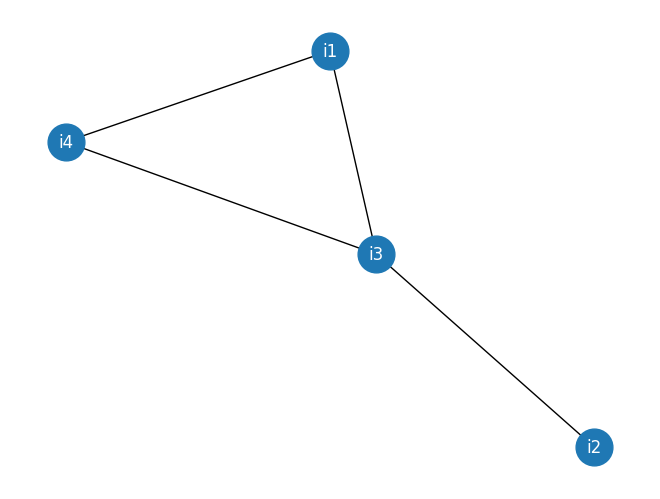

In [116]:
G = nx.from_pandas_adjacency(adj)
pos = nx.spring_layout(G, seed=3113794652)  # positions for all nodes
nx.draw(G, pos=pos, node_size=700)
nx.draw_networkx_labels(G, pos=pos, font_color='#fff')

In [117]:
for n in G.nodes():
    print(n)

i1
i2
i3
i4
